In [1]:
from src import read_yfinance_crypto_data
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import yfinance as yf
import ewtpy
yf.__cache__ = {}

/root/cryptobot-enviroment/.venv/lib/python3.12/site-packages/numpy/_core/getlimits.py:545: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)
2025-01-08 03:15:25.204907: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-08 03:15:25.213230: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-08 03:15:25.232032: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736316925.256740   11158 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plu

In [2]:
seq_len = 90
tested_model = "xrp-p90-1f-2L.keras"

In [3]:
%reload_ext autoreload
%autoreload 2

#simulate training scaler
ticker = yf.Ticker("XRP-USD",)
puppet = ticker.history("max", "1d")

puppet = puppet["Close"].values.reshape(-1,1)
trainingScaler = MinMaxScaler()
normalizedTrainingData = trainingScaler.fit_transform(puppet)
normalizedTrainingData.shape

(2617, 1)

In [14]:
# connect to yfinance and get last 180 days data (data preparation eats first 90 days)
df = read_yfinance_crypto_data("XRP-USD", "5y", "1d")
pastData = df["Close"].values.reshape(-1,1)

# normalize the pastData on the training scaler
normalizedPastData = trainingScaler.transform(pastData)
normalizedPastData.shape

(1827, 1)

In [5]:
# load model
model = tf.keras.models.load_model(f"./saved_models/{tested_model}")
model.summary()

2025-01-08 03:15:29.770049: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/root/cryptobot-enviroment/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 90, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 90, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,604 (947.68 KB)

 Trainable params: 121,301 (473.83 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 121,303 (473.84 KB)

In [15]:
# Initial parameters
initial_sum = 100
buyed = False
predictions = []
sum_by_epoch = []

# Main trading loop
for i in range(seq_len, len(normalizedPastData)):
    print(f"Iteration {i}")
    
    # Get input data
    inputs = normalizedPastData[i-seq_len:i]
    
    # Reshape EWT output for model
    
    # Make prediction
    pred = model(inputs)
    predictions.append(pred[0])
    
    # Calculate price difference
    predicted_price_difference = pred[0] - pastData[i-1]
    print(f"Predicted diff: {predicted_price_difference}")
    
    # Stop Loss logic
    stop_loss_percentage = 0.05  # 5% stop loss
    current_position_value = pastData[i-1] * buy_amount if buyed else 0
    
    if (buyed):
        operation_difference = pastData[i-1] - buy_value
        print(f"Operation difference: {operation_difference}")
        
        # Check stop loss
        if abs(operation_difference) > stop_loss_percentage * buy_value:
            print(f"Stop Loss triggered at {pastData[i-1]}")
            initial_sum += operation_difference[0] * buy_amount[0]
            buyed = False
        
        # Realize gains
        elif operation_difference > 0:
            take_profit_percentage = 0.1  # 15% take profit
            
            if operation_difference >= take_profit_percentage * buy_value:
                print(f"Take Profit triggered at {pastData[i-1]}")
                initial_sum += operation_difference[0] * buy_amount[0]
                buyed = False
    
    # Buy logic
    if (predicted_price_difference > 0) and not buyed:
        buy_value = pastData[i-1]
        buy_amount = initial_sum / pastData[i-1]
        print(f"Buying at {buy_value}, amount: {buy_amount}")
        buyed = True
    
    # Update sum_by_epoch
    sum_by_epoch.append((initial_sum - 100)/10)
    
print("Final sum:", initial_sum)

Iteration 90
Predicted diff: [-0.10292949]
Iteration 91
Predicted diff: [-0.10183138]
Iteration 92
Predicted diff: [-0.1064498]
Iteration 93
Predicted diff: [-0.10409357]
Iteration 94
Predicted diff: [-0.09117317]
Iteration 95
Predicted diff: [-0.09346896]
Iteration 96
Predicted diff: [-0.08307526]
Iteration 97
Predicted diff: [-0.08168865]
Iteration 98
Predicted diff: [-0.08173943]
Iteration 99
Predicted diff: [-0.07188815]
Iteration 100
Predicted diff: [-0.07815643]
Iteration 101
Predicted diff: [-0.08263262]
Iteration 102
Predicted diff: [-0.08865428]
Iteration 103
Predicted diff: [-0.08239193]
Iteration 104
Predicted diff: [-0.07565323]
Iteration 105
Predicted diff: [-0.08212969]
Iteration 106
Predicted diff: [-0.08750241]
Iteration 107
Predicted diff: [-0.09271868]
Iteration 108
Predicted diff: [-0.08887358]
Iteration 109
Predicted diff: [-0.08995891]
Iteration 110
Predicted diff: [-0.08758684]
Iteration 111
Predicted diff: [-0.09032632]
Iteration 112
Predicted diff: [-0.10333371]

In [16]:
predictions

[<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.09257652], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.09026162], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.0944192], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.09416343], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.09629083], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.09459403], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.10705975], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.10604335], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.10359556], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.10938185], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.11194756], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.10756938], dtype=float32)>,
 <tf.

(1827, 1) (1827,) 1737

Summary:
Total iterations: 1737
Average growth rate: 0.12%


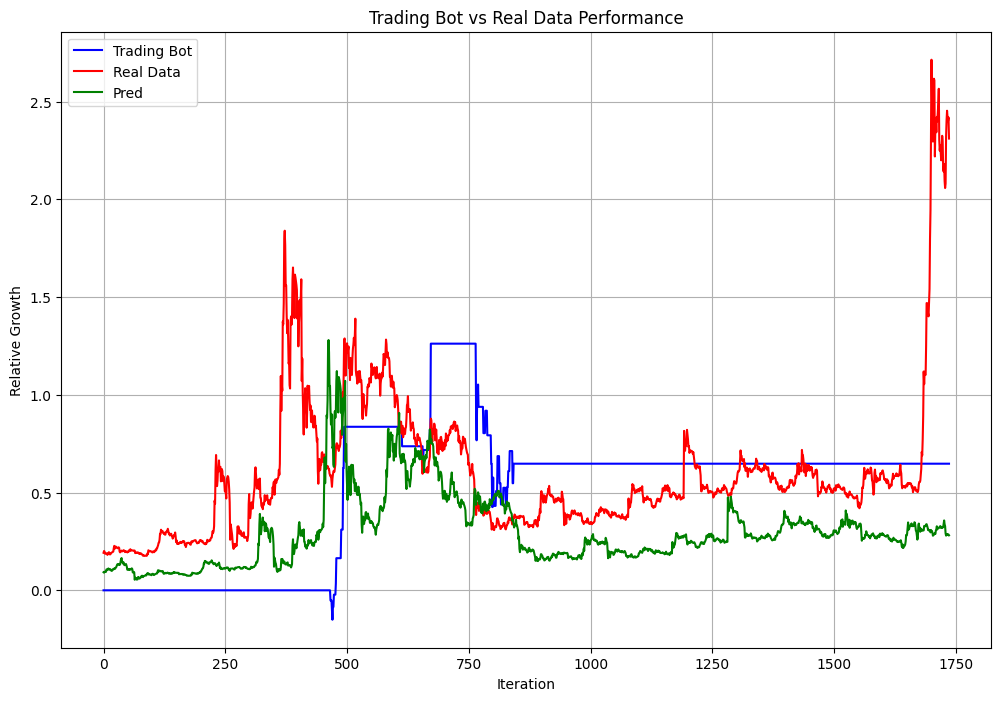

In [17]:
import matplotlib.pyplot as plt
import numpy as np
timeseries = df.index
print(pastData.shape, timeseries.shape,  len(sum_by_epoch))

# Print summary statistics
print("\nSummary:")
print(f"Total iterations: {len(sum_by_epoch)}")
print(f"Average growth rate: {(sum_by_epoch[-1] + 1)**(1/len(sum_by_epoch)) - 1:.2%}")

# Plot results (including real data)
plt.figure(figsize=(12,8))

plt.plot(range(len(sum_by_epoch)), [x/10 for x in sum_by_epoch], label='Trading Bot', color='blue')
plt.plot(range(len(pastData)-seq_len), pastData[seq_len:], label='Real Data', color='red')
plt.plot(range(len(predictions)), predictions[:], label='Pred', color='green')

# Add title and labels
plt.title('Trading Bot vs Real Data Performance')
plt.xlabel('Iteration')
plt.ylabel('Relative Growth')

# Add legend
plt.legend()

# Grid and axis limits
plt.grid(True)
# Show the plot
plt.show()